# **Data Preprocessing & Pandas with Kaggle Playground (Oct 2025)**

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# na_values covers common placeholders; adjust if your competition uses special tokens
read_csv_opts = dict(low_memory=False, na_values=["", "NA", "NaN", "null"])

train = pd.read_csv('train.csv', **read_csv_opts)
test  = pd.read_csv('test.csv', **read_csv_opts)

print("train shape:", train.shape)
print("test shape:", test.shape)


train shape: (517754, 14)
test shape: (172585, 13)


## Section 1 - Load & First Look

In [5]:
display(train.head())
display(test.head(3))

print("\nColumns in train:")
print(list(train.columns))

print("\nColumns in test:")
print(list(test.columns))

# A random peek 
display(train.sample(5))


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1



Columns in train:
['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']

Columns in test:
['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
70087,70087,rural,4,0.40,35,dim,foggy,True,False,afternoon,False,False,1,0.25
361006,361006,urban,3,0.27,35,daylight,foggy,False,False,afternoon,False,False,2,0.21
439009,439009,highway,3,0.49,60,daylight,clear,False,True,evening,True,False,2,0.34
269133,269133,rural,3,0.73,70,night,clear,False,False,evening,False,True,4,0.70
501136,501136,urban,3,0.17,45,night,foggy,False,True,morning,True,False,1,0.34


In [6]:
# Built in method for inspection
print("=== train.info() ===")
train.info()
print("\n=== test.info() ===")
test.info()

# dtype summary tables
dtype_train = train.dtypes.value_counts().rename_axis("dtype").to_frame("count")
dtype_test  = test.dtypes.value_counts().rename_axis("dtype").to_frame("count")
display(dtype_train.style.set_caption("Train dtypes"))
display(dtype_test.style.set_caption("Test dtypes"))


=== train.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtyp

,count
dtype,
int64,4
object,4
bool,4
float64,2


,count
dtype,
int64,4
object,4
bool,4
float64,1


In [7]:
# Numeric summary - Averages, Percentiles, etc.
display(train.describe().T.style.set_caption("Numeric summary (train)"))

# Categorical summary: how many unique values and top frequencies
def categorical_overview(df, max_cols=20):
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    overview = []
    for c in cat_cols[:max_cols]:
        vc = df[c].value_counts(dropna=False)
        top = vc.index[0] if len(vc) else None
        top_count = vc.iloc[0] if len(vc) else None
        overview.append({
            "column": c,
            "n_unique": df[c].nunique(dropna=True),
            "most_frequent": top,
            "most_frequent_count": int(top_count) if top_count is not None else None,
            "n_missing": int(df[c].isna().sum())
        })
    return pd.DataFrame(overview).sort_values("n_missing", ascending=False)

display(categorical_overview(train).style.set_caption("Categorical overview (train)"))


,count,mean,std,min,25%,50%,75%,max
id,517754.000000,258876.500000,149462.849975,0.000000,129438.250000,258876.500000,388314.750000,517753.000000
num_lanes,517754.000000,2.491511,1.120434,1.000000,1.000000,2.000000,3.000000,4.000000
curvature,517754.000000,0.488719,0.272563,0.000000,0.260000,0.510000,0.710000,1.000000
speed_limit,517754.000000,46.112575,15.788521,25.000000,35.000000,45.000000,60.000000,70.000000
num_reported_accidents,517754.000000,1.187970,0.895961,0.000000,1.000000,1.000000,2.000000,7.000000
accident_risk,517754.000000,0.352377,0.166417,0.000000,0.230000,0.340000,0.460000,1.000000


,column,n_unique,most_frequent,most_frequent_count,n_missing
0,road_type,3,highway,173672,0
1,lighting,3,dim,183826,0
2,weather,3,foggy,181463,0
3,time_of_day,3,morning,173410,0


In [8]:
def missing_summary(df, min_missing=1):
    miss = df.isnull().sum()
    miss = miss[miss >= min_missing].sort_values(ascending=False)
    if miss.empty:
        return pd.DataFrame({"column": [], "n_missing": [], "pct_missing": []})
    out = pd.DataFrame({
        "column": miss.index,
        "n_missing": miss.values,
        "pct_missing": (miss.values / len(df) * 100).round(2)
    })
    return out

print("=== Missing values (train) ===")
display(missing_summary(train))
print("=== Missing values (test) ===")
display(missing_summary(test))


=== Missing values (train) ===


,column,n_missing,pct_missing


=== Missing values (test) ===


,column,n_missing,pct_missing


## Section 2 - Data Quality Checks + Data Cleaning

In [9]:
# Count duplicates
print("Number of duplicate rows in train:", train.duplicated().sum())
print("Number of duplicate rows in test:", test.duplicated().sum())

# Optionally drop them (if any)
# train = train.drop_duplicates().reset_index(drop=True)
# test = test.drop_duplicates().reset_index(drop=True)


Number of duplicate rows in train: 0
Number of duplicate rows in test: 0


In [10]:
# Check for and "impossible" values, such as negative or weird values in numeric columns
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
print("Min/max values for numeric columns:")
display(train[numeric_cols].agg(['min', 'max']).T)


Min/max values for numeric columns:


,min,max
id,0.0,517753.0
num_lanes,1.0,4.0
curvature,0.0,1.0
speed_limit,25.0,70.0
num_reported_accidents,0.0,7.0
accident_risk,0.0,1.0


In [11]:
# Compare categories between train and test

cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_cats = set(train[col].unique())
    test_cats = set(test[col].unique())
    extra_in_test = test_cats - train_cats
    if extra_in_test:
        print(f"'{col}' has categories in test not seen in train: {extra_in_test}")


In [12]:
# Adjusting data types

# Convert categorical object columns to 'category' dtype
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# Convert boolean columns to integers
bool_cols = train.select_dtypes(include=['bool']).columns
for col in bool_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      517754 non-null  int64   
 1   road_type               517754 non-null  category
 2   num_lanes               517754 non-null  int64   
 3   curvature               517754 non-null  float64 
 4   speed_limit             517754 non-null  int64   
 5   lighting                517754 non-null  category
 6   weather                 517754 non-null  category
 7   road_signs_present      517754 non-null  int64   
 8   public_road             517754 non-null  int64   
 9   time_of_day             517754 non-null  category
 10  holiday                 517754 non-null  int64   
 11  school_season           517754 non-null  int64   
 12  num_reported_accidents  517754 non-null  int64   
 13  accident_risk           517754 non-null  float64 
dtypes: c

In [15]:
# double check shapes and columns

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())

# train shape different to test shape as training set contains target (accident risk)

Train shape: (517754, 14)
Test shape: (172585, 13)
Train columns: ['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk']
Test columns: ['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']


## Section 3 - Exploratory Data Analysis

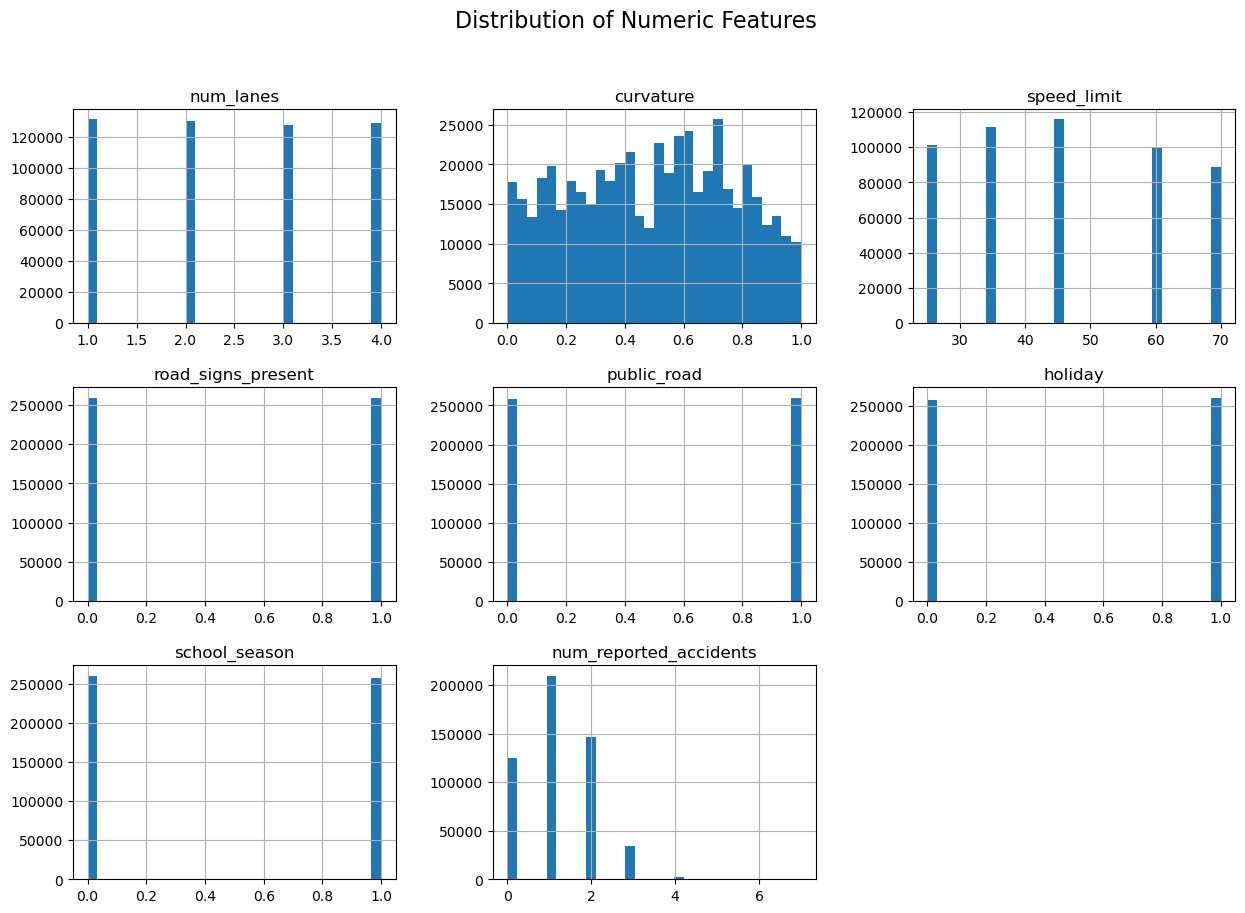

,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
road_signs_present,517754.0,0.499204,0.500000,0.0,0.00,0.00,1.00,1.0
public_road,517754.0,0.502256,0.499995,0.0,0.00,1.00,1.00,1.0
holiday,517754.0,0.503498,0.499988,0.0,0.00,1.00,1.00,1.0
school_season,517754.0,0.497514,0.499994,0.0,0.00,0.00,1.00,1.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0


In [18]:
# Histograms for numeric features
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'accident_risk'], errors='ignore')
train[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

# Summary stats
display(train[numeric_cols].describe().T)


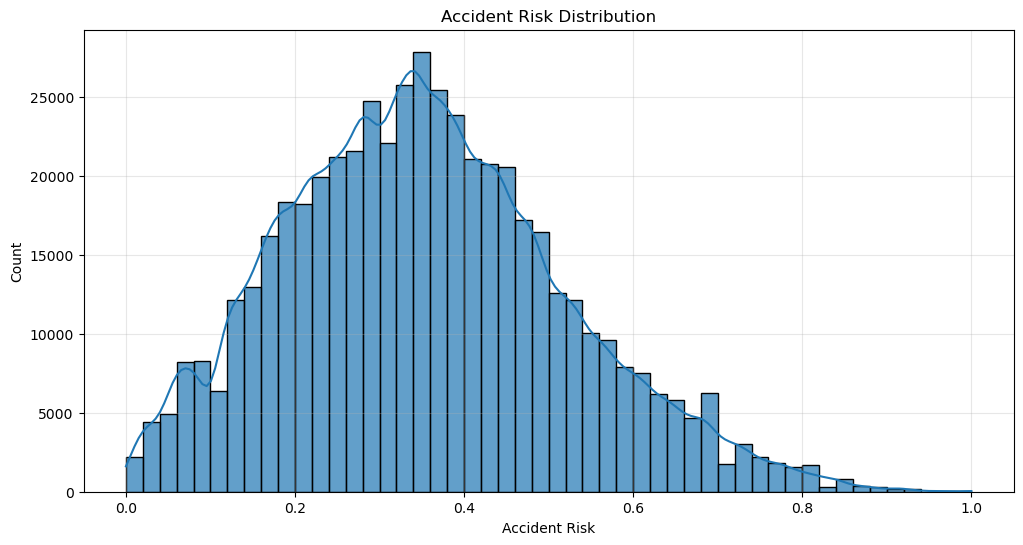

In [19]:
# Accident risk distribution

plt.figure(figsize=(12,6))
sns.histplot(train['accident_risk'], bins=50, kde=True, alpha=0.7)
plt.title('Accident Risk Distribution')
plt.xlabel('Accident Risk')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

In [20]:
for col in cat_cols:
    display(train.groupby(col, observed = False)['accident_risk'].agg(['mean','count']).sort_values('mean', ascending=False))

,mean,count
road_type,,
urban,0.357456,171363
rural,0.349997,172719
highway,0.349734,173672


,mean,count
lighting,,
night,0.470467,155913
daylight,0.302923,178015
dim,0.300109,183826


,mean,count
weather,,
foggy,0.386305,181463
rainy,0.361494,156985
clear,0.310060,179306


,mean,count
time_of_day,,
evening,0.354736,172837
afternoon,0.351428,171507
morning,0.350966,173410


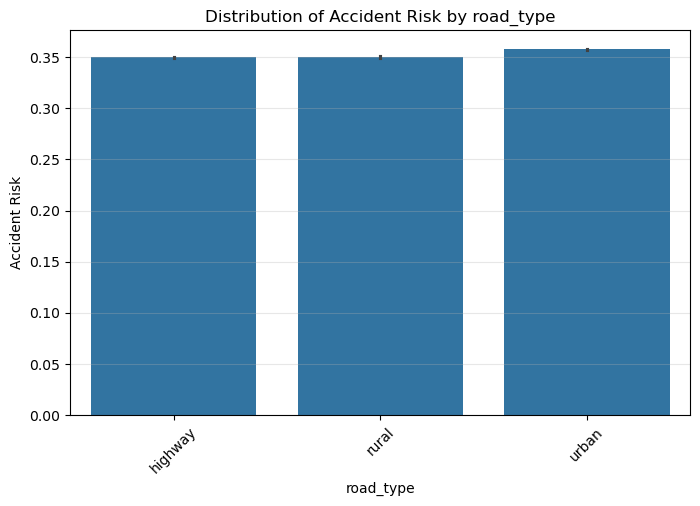

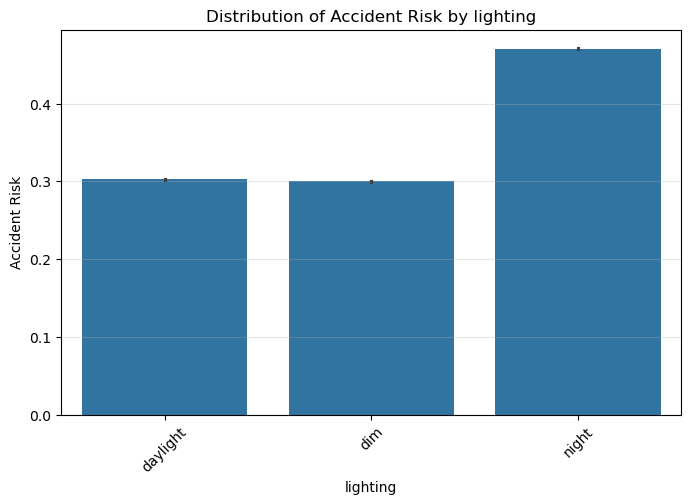

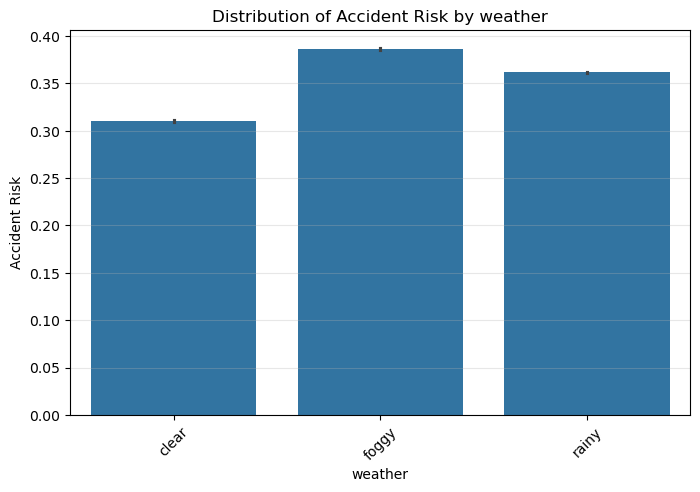

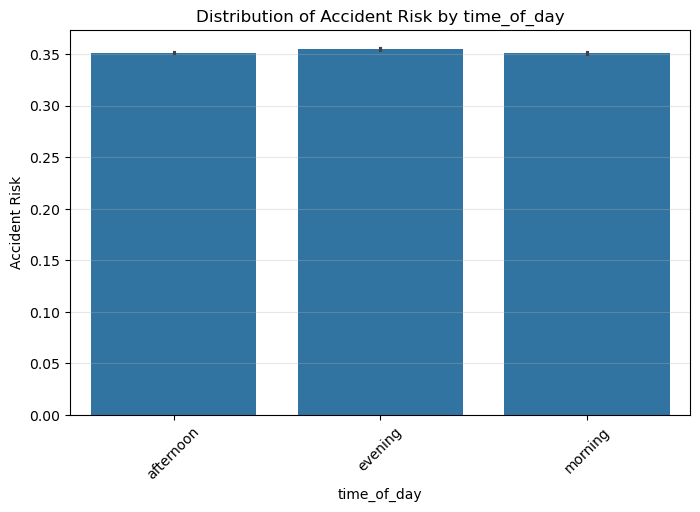

In [28]:
def distribution(col):  

    plt.figure(figsize=(8,5))
    sns.barplot(
        x=col,
        y='accident_risk',
        data=train,
        order=train.groupby(col, observed = False)['accident_risk'].mean().index,
    )

    plt.title(f'Distribution of Accident Risk by {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Accident Risk')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    return plt.show()

for col in cat_cols:
    distribution(col)

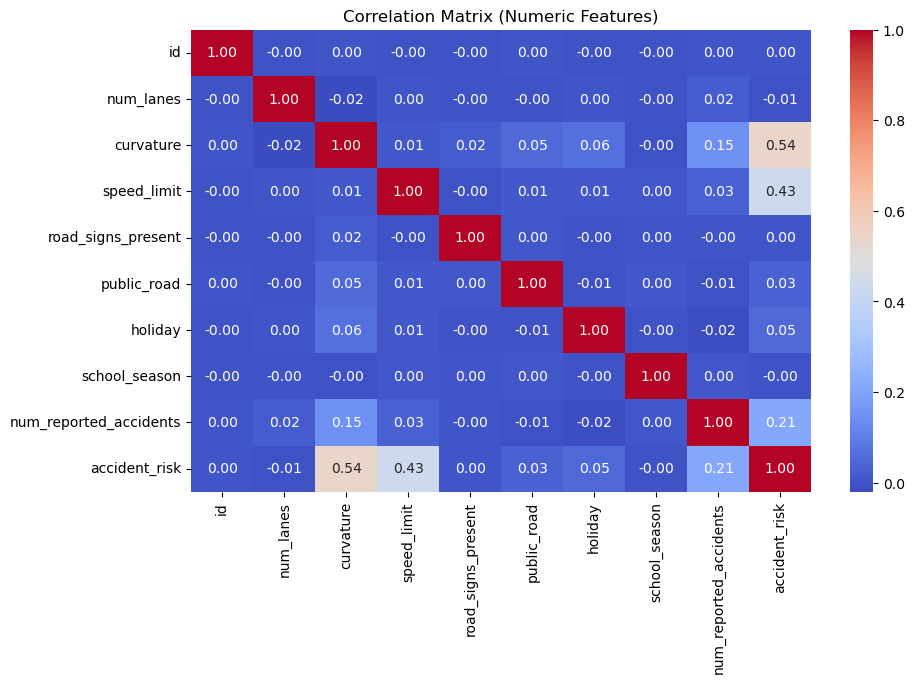

In [27]:
# Correlation matrix for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

## Section 4 - Encoding & Regression

In [30]:
TARGET = 'accident_risk'

# Separate features and target (accident risk is what we're trying to predict)
X = train.drop(columns=[TARGET, 'id'])
y = train[TARGET].copy()
X_test = test.drop(columns=['id'])

# One-hot encode categoricals (dummy variables)
cat_cols = X.select_dtypes(include=['object','category']).columns
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)

# Align columns (important for Kaggle)
X_enc, X_test_enc = X_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

print("Train encoded shape:", X_enc.shape)
print("Test  encoded shape:", X_test_enc.shape)

Train encoded shape: (517754, 20)
Test  encoded shape: (172585, 20)


In [31]:
reg = LinearRegression().fit(X_enc, y)

intercept = reg.intercept_
slope = reg.coef_[0]

print(f'The R2 coefficient of determination is {reg.score(X_enc, y):.3f}')
print(f'The intercept is {intercept:.4f}')
print(f'Slope: {slope:.4f}')

The R2 coefficient of determination is 0.805
The intercept is -0.0535
Slope: 0.0006


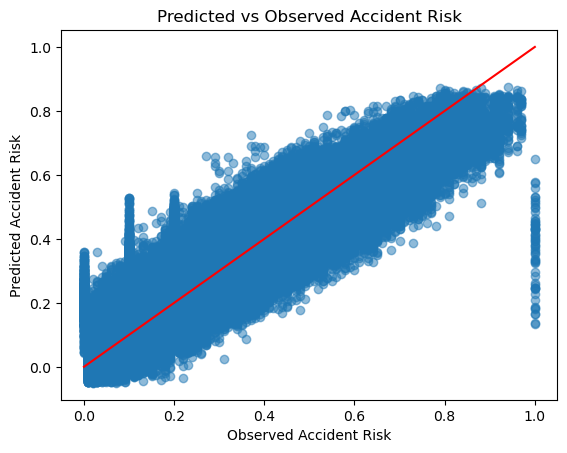

In [32]:
# plot predicted vs observed, to see how the model fits
y_hat = reg.predict(X_enc)

plt.scatter(y, y_hat, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r')
plt.xlabel("Observed Accident Risk")
plt.ylabel("Predicted Accident Risk")
plt.title("Predicted vs Observed Accident Risk")
plt.show()

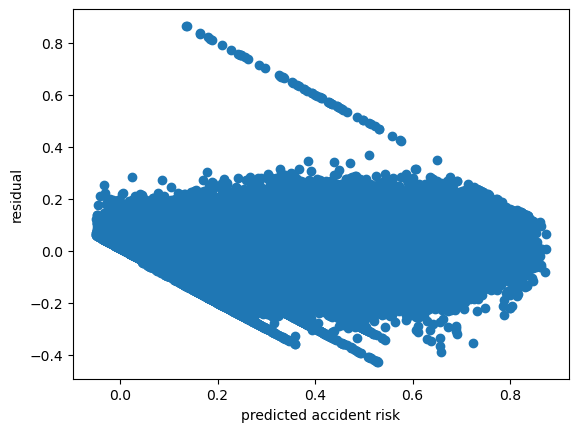

In [33]:
residuals = y - y_hat

plt.scatter(y_hat, residuals)
plt.xlabel('predicted accident risk')
plt.ylabel('residual')
plt.show()

In [34]:
# look at coefficients to see effect
coefs = pd.DataFrame(abs(reg.coef_), index=X_enc.columns)
coefs

,0
num_lanes,0.000627
curvature,0.324749
speed_limit,0.005099
road_signs_present,0.001165
public_road,0.000743
holiday,0.000283
school_season,0.000348
num_reported_accidents,0.015743
road_type_highway,0.000221
road_type_rural,0.000405


In [35]:
# scale data
scaler = StandardScaler()
Z_train = scaler.fit_transform(X_enc)

reg1 = LinearRegression().fit(Z_train, y)

intercept = reg1.intercept_
slope = reg1.coef_[0]

# The r2 value is the same after the data has been scaled.
print(f'The R2 coefficient of determination is {reg1.score(Z_train, y):.3f}')

# these values are changed.
print(f'The intercept is {intercept:.4f}')
print(f'Slope: {slope:.4f}')


The R2 coefficient of determination is 0.805
The intercept is 0.3524
Slope: 0.0007


In [36]:
# now we can inspect coefficients
coefs = pd.DataFrame(abs(reg1.coef_), index=X_enc.columns, columns=['coefficient'])
coefs.sort_values('coefficient', ascending = False)

,coefficient
curvature,0.088515
speed_limit,0.080498
lighting_night,0.058737
weather_clear,0.028981
lighting_dim,0.028371
lighting_daylight,0.028147
weather_rainy,0.014743
weather_foggy,0.014697
num_reported_accidents,0.014105
num_lanes,0.000702


In [37]:
# scale test data in same way
Z_test = scaler.transform(X_test_enc)

# apply model to get final predicted values.
y_test_hat = reg1.predict(Z_test)

In [39]:
# submission = test[['id']].copy() # take id col for kaggle
# submission['accident_risk'] = y_test_hat
# submission.to_csv('submission.csv', index=False)

Submission is now finished. It's not perfect but it puts numbers on the page. There are a number of things that can be done to improve the model:

- some variables have a bigger impact than others, so perhaps we can exclude the features that dont have much impact
- outliers have not been considered, standard scaler has helped handle some outliers but I don't know what it actually does.